In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import os
import pandas as pd
from tqdm import tqdm
import math
from scipy.stats import norm

import random
random.seed(418)  # 设置种子值

## 1. 设定参数

In [36]:
class Config:
    # 训练设备
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 训练参数
    epochs = 500 
    batch_size = 32
    lr = 1e-4 

    # 模型参数
    window_size = 20

    # 设置断点
    checkpoint_interval = 25


    # diffusion部分参数
    timesteps = 1000
    beta_start = 1e-4
    beta_end = 0.02
    beta = torch.linspace(beta_start, beta_end, timesteps)
    alpha = 1 - beta
    alpha_bar = torch.cumprod(alpha, dim=0).to(device)

    # transformer部分参数
    output_dim = window_size  # 输出词汇表大小
    d_model = 512  # 词嵌入维度
    num_head = 8  # 多头注意力头数
    num_encoder_layers = 3 # 编码器层数
    num_decoder_layers = 3 # 解码器层数 
    dim_feedforward = 2048  # 前馈神经网络隐藏层维度
    dropout = 0.1  # Dropout 概率

config = Config()

# 检查是否有可用的 GPU
print(f"Using device: {config.device}")

Using device: cuda


## 2. 处理数据

### 2.1 从文件中提取

In [37]:
# 提取sequence数据
folder_path = "data/sequence"
files = os.listdir(folder_path)
all_sequence = {}
for file in files:
    # 获取文件的完整路径
    file_path = os.path.join(folder_path, file)
    
    # 检查文件扩展名，确保是 txt 文件
    if file.endswith('.txt'):
        filename_without_extension = os.path.splitext(file)[0]
        with open(file_path, 'r') as file:
            data = file.read()
            data = pd.DataFrame({'antigen' : list(data)})
            all_sequence[filename_without_extension] = data

folder_path = 'data/antigens'
files = os.listdir(folder_path)
all_epitope_curve = {}
all_amino_position = {}
for file in files:
    file_path = os.path.join(folder_path, file, 'epitope-curve.csv')
    if file_path.endswith(".csv"):
        data = pd.read_csv(file_path)
        all_epitope_curve[file] = data['response frequency']
        all_amino_position[file] = data['position']

# 合并两张表(数据类型为字典)
merged_sequence = {}
for key in all_sequence:
    merged_sequence[key] = pd.concat([all_sequence[key],all_epitope_curve[key], all_amino_position[key]], axis=1, ignore_index=False)

# 拆分输入和输出值
#将sample和labels值拆分
x_list = []
y_list = []
position_list = []
sequences_length = []
names = []
for name, value in merged_sequence.items():
    y_list.append(value["antigen"])
    x_list.append(value['response frequency'])
    position_list.append(value['position'])
    sequences_length.append(len(value))
    names.append(name)

### 2.1 创建dataloader

使用正态映射

In [38]:
def map_to_infinite_range(x, mu=0, sigma=1):
    """
    将[0,1]范围内的值映射到(-∞, +∞)
    
    输入:
        x: [0,1]范围内的值
    
    返回:
        映射到实数范围的值
    """
    # 处理边界情况，避免产生无限值
    eps = np.finfo(float).eps
    x = np.clip(x, eps, 1-eps)
    
    return norm.ppf(x, loc=mu, scale=sigma)

def map_back_to_unit_range(y, mu=0, sigma=1):
    """
    将实数范围内的值映射回[0,1]
    
    输入:
        y: 实数范围内的值
    
    返回:
        映射回[0,1]范围的值
    """
    return norm.cdf(y, loc=mu, scale=sigma)


切割片段

In [39]:
def split_at_custom_empty(sequence):
    result = []
    temp = []
    for item in sequence:
        if not np.isnan(item):
            temp.append(item)
        else:
            if temp:
                result.append(temp)
                temp = []
    if temp:
        result.append(temp)
    return result

In [40]:
split = []
for i in x_list:
    split.extend(split_at_custom_empty(i))
len(split)
sum([len(i)>20 for i in split])

964

##### get_embedding

In [41]:
class get_embedding():
    """
    输入:(上步得到的所有序列的列表)
        1. amino_list, 
        2. target_list, 
        3. position_list,
    得到:
        1. targets_sequence: [sequence_length]
        2. amino_sequence: [sequence_length, C=20]
    """
    def __init__(self, amino_list, targets_list, position_list):
        """
        
        """
        self.amino_list = amino_list
        self.targets_list = targets_list
        self.position_list = position_list
        self.x, self.y = self.get_sequence()
    
    def get_position_embedding(self, p, d_model = config.window_size):
        """
        位置编码(正余弦)
        """
        # w = 10000^(2i/d_model) 
        # w: seq_len
        w = 1/ (10000 ** ((torch.arange(start=0, end=d_model//2, dtype=torch.float32) / (d_model//2))))
        # p_emb: seq_len, 20//2 
        p_emb = p[:, None].repeat(1, d_model//2) * w
        # p_emb: seq_len, 20
        p_emb = torch.cat([torch.sin(p_emb), torch.cos(p_emb)], dim=-1)
        return p_emb
    
    def one_hot_encode_sequence(self, sequence):
        """
        对氨基酸序列进行 one-hot 编码
        """
        # 氨基酸字母表（标准20种氨基酸）
        AMINO_ACIDS = "ACDEFGHIKLMNPQRSTVWY"
        aa_to_index = {aa: i for i, aa in enumerate(AMINO_ACIDS)}  # 将氨基酸映射到索引
        
        input_sequence_length = len(sequence)
        one_hot = np.zeros((input_sequence_length, len(aa_to_index)))  # 初始化 one-hot 矩阵
        for i, aa in enumerate(sequence):
            if aa in aa_to_index:
                one_hot[i, aa_to_index[aa]] = 1
        return one_hot
    
    def get_sequence(self):
        x, y = [], []

        for amino, target, p in zip(self.amino_list, self.targets_list, self.position_list):
            # 获得位置编码
            p_emb_seq = np.array(self.get_position_embedding(torch.Tensor(p)))
            # 获得one_hot编码
            amino_one_hot_seq = self.one_hot_encode_sequence(amino)
            # window = position_emb + one_hot_emb
            y.append(np.array( amino_one_hot_seq + p_emb_seq)) 
            x.append(map_to_infinite_range(np.array(target)))

        return x, y
    
    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [42]:
# 获取原始数据的索引
indices = np.arange(len(y_list))

# 分割数据和索引
train_seq, test_seq, train_targets, test_targets, train_position, test_position, train_idx, test_idx = train_test_split(y_list, x_list, position_list, indices, test_size=0.2, random_state=42)

train_embedding =  get_embedding(train_seq, train_targets, train_position)
test_embedding =  get_embedding(test_seq, test_targets, test_position)

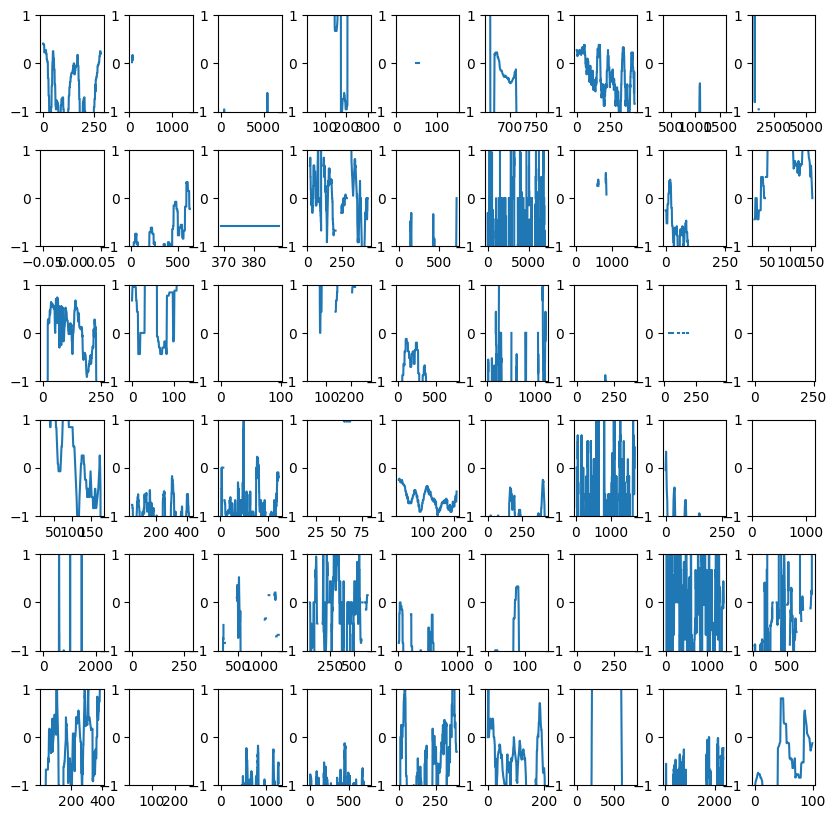

In [43]:
num_plots = 54
rows, cols = 6, 9
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    # ax.plot(predicted[i]) # blue
    ax.plot(train_embedding[i][0])
    ax.set_ylim(-1, 1)
# 调整子图之间的间距
plt.subplots_adjust(hspace=0.4, wspace=0.4)

##### AminoDataset

In [44]:
class AminoDataset(Dataset):
    def __init__(self, embeddings, block_size, overlap_ratio=0.2, step=3):
        """
        输入：
            embeddings: get_embedding后得到的train/test_embedding
            block_size:  block的长度, 对应的是target_list,
            overlap_ratio: 相邻块之间的重叠比例(默认0.2)

        """    
        self.window_size = block_size * 3
        self.embeddings = embeddings
        self.block_size = block_size
        self.overlap = int(block_size * overlap_ratio)  # 计算实际重叠长度
        self.step = step

        self.block_0, self.block_left, self.window = self.create_windows()

    def create_windows(self):
        x_left, x_0, y_condition = [], [], []
        for x, y in self.embeddings:

            # 计算步长（块长度减去重叠部分）
            # step = max(1, self.block_size - self.overlap)  # 确保步长≥1
            seq_length = x.shape[0]
        
            # 创建带重叠的块
            for i in range(0, seq_length - self.block_size, self.step):
                
                # 确保不超过序列长度
                if i + 3 * self.block_size - 2 *  self.overlap > seq_length:
                    break
                    
                # 前一个块                
                block_left = x[i:i + self.block_size]
                
                # 当前块
                block_0 = x[i + self.block_size - self.overlap:i + 2 * self.block_size - self.overlap]
                
         
                window = y[i:i + self.block_size * 3 - self.overlap * 2, :]

                # 设置最大空值数
                max_nans = 5
                
                # 仅当所有块长度符合要求时加入
                if len(block_left) == self.block_size and len(block_0) == self.block_size:
                    if torch.isnan(block_0).sum() < max_nans:
                        x_left.append(torch.nan_to_num(block_left))
                        x_0.append(torch.nan_to_num(block_0))
                        y_condition.append(torch.nan_to_num(window))

            
        # 如果所有序列都过短，抛出明确错误
            if len(x_0) == 0:
                raise ValueError(
                    f"无法生成有效样本：请检查输入数据长度是否≥{self.block_size + self.overlap}，"
                    f"或调整block_size（当前={self.block_size})/overlap_ratio（当前={self.overlap/self.block_size})"
                )
        return x_0, x_left, y_condition
        
    def __len__(self):
        return len(self.block_0)

    def __getitem__(self, idx):
        block_0 = self.block_0[idx]
        block_left = self.block_left[idx]    
        window = self.window[idx]
        return block_0, block_left, window

In [45]:
train_dataset = AminoDataset(train_embedding, config.window_size)
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, drop_last=True)

In [46]:
for block_0, block_left, condition in train_loader:
    print(block_left.shape)
    print(block_0.shape)
    break
print(f"train_loader的大小:{len(train_loader)}")

torch.Size([32, 20])
torch.Size([32, 20])
train_loader的大小:1639


##### partition_sequence

In [47]:
def partition_sequence(target_sequence, amino_sequence, block_size=config.window_size, overlap=5):
    """将序列分割为重叠块"""
    stride = int(block_size - overlap)
    seq_length = len(amino_sequence)
    num_blocks = int((seq_length - 3 * block_size + 2 * overlap) // stride + 1)
    condition_blocks = []
    target_blocks = []
    for i in range(num_blocks):
        start = i * stride
        mid = start + block_size - overlap
        end = mid + block_size * 2 - overlap
        condition_blocks.append(amino_sequence[start:end])
        target_blocks.append(target_sequence[mid:mid + block_size])
    length = mid + overlap
    return target_blocks, condition_blocks, length  

In [48]:
def merge_blocks(blocks, original_length, overlap):
    """
    合并分块数据（重叠部分加权平均）
    Args:
        blocks: [N, block_size, C]
        original_length: 原始序列长度 T
        overlap: 重叠步长
    """
    stride = blocks.shape[1] - overlap
    output = torch.zeros(original_length, blocks.shape[2]).to(config.device)
    count = torch.zeros(original_length, 1).to(config.device)
    
    for i, block in enumerate(blocks):
        block = block.to(config.device)
        start = (i * stride)
        end = start + blocks.shape[1]
        
        # 重叠部分线性加权（中心权重高）
        weights = torch.ones_like(block).to(config.device)
        if overlap > 0:
            weights[:overlap//2] = torch.linspace(1, 1, overlap//2).unsqueeze(1)
            weights[-overlap//2:] = torch.linspace(1, 1, overlap//2 + 1).unsqueeze(1)
        
        output[start:end] += block * weights
        count[start:end] += weights
    
    return output / count.clamp(min=1.0)

在merge之后无法恢复原长，需要关注一下对齐问题

In [49]:
# target = test_embedding[1][0]
# amino = test_embedding[1][1]
# target_partition, condition_partition, length = partition_sequence(target, amino)
# target_partition = torch.stack(target_partition).unsqueeze(2)
# # print(target_partition.shape)
# target_merged = merge_blocks(target_partition, length, 5)
# # print("原始序列:", target[15:-23][:10])
# # print("还原序列:", target_merged[:10])
# plt.plot(target[15:-23])
# plt.plot(target_merged)
# print("原始长度:", len(target[15:-26]))
# print("还原长度:", len(target_merged))

## 4. 定义模型

### 4.1 transformer

In [50]:
def get_time_embedding(t, dim):
    # t: 时间步张量, shape=(batch_size, 1)
    # dim: 嵌入向量的维度
    half_dim = dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)
    emb = t.float() * emb.unsqueeze(0).to(config.device)  
    # emb.shape ==> (batch_size, half_dim)
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)  # shape=(batch_size, dim)
    return emb.to(config.device)

In [51]:
# 定义 Transformer 模型
class TransformerModel(nn.Module):
    def __init__(self,output_dim = config.output_dim, d_model=config.d_model, nhead=config.num_head, 
                 num_encoder_layers=config.num_encoder_layers, num_decoder_layers=config.num_decoder_layers, 
                 dim_feedforward=config.dim_feedforward, dropout=config.dropout):
        
        super(TransformerModel, self).__init__()
        self.d_model = d_model
        self.window_size = config.window_size
    

        # block_left的编码器
        self.block_left_encoder = nn.Sequential(
            nn.Linear(self.window_size, 128), # block_0: (btach_size, window_size)
            nn.ReLU(),
            nn.Linear(128, d_model),
            nn.LayerNorm(d_model)
        )
        
        # 时间步的编码器
        self.time_encoder = nn.Sequential(
            nn.Linear(self.window_size, 128), # t: (btach_size, window_size)
            nn.ReLU(),
            nn.Linear(128, d_model),
            nn.LayerNorm(d_model)
        )
        
        # x_t 的编码器
        self.xt_encoder = nn.Sequential(
            nn.Linear(self.window_size, 128),  # block_0: (btach_size, window_size)
            nn.ReLU(),
            nn.Linear(128, d_model),
            nn.LayerNorm(d_model)
        )

        # amino condition 的编码器
        # 修改condition_projection部分
        self.condition_projection = nn.Sequential(
            nn.Linear(20, 256),  # 增加中间维度
            nn.GELU(),          # 使用GELU激活函数
            nn.Linear(256, d_model),
            nn.LayerNorm(d_model)
        )

        # Condition Transformer 编码器
        self.condition_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
                batch_first=True,
                activation='gelu'  # 使用GELU
            ),
            num_layers=3  # 增加层数
        )

        # # Condition的Skip路径
        # self.condition_skip = nn.Linear(d_model, d_model)
        
        # Transformer
        self.transformer = nn.Transformer(d_model=d_model,
                                          nhead=nhead,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=dim_feedforward,
                                          dropout=dropout, batch_first=True)
        
        # Skip Connection模块
        self.skip_projection = nn.Sequential(
            nn.Linear(d_model * 2, d_model * 4),  # 扩张维度
            nn.ReLU(),
            nn.Linear(d_model * 4, d_model),     # 压缩回原维度
            nn.LayerNorm(d_model)
        )

        # 输出层（融合主输出+Skip输出）
        # 修改fc_out
        self.fc_out = nn.Sequential(
            nn.Linear(d_model * 2, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, output_dim)
        )

        
    def forward(self, xt, block_left, condition, t):
        # === 编码阶段 ===
        # 编码窗口序列
        block_left_feat = self.block_left_encoder(block_left)

        # Condition编码
        condition_proj = self.condition_projection(condition)  # (B, W, D)
        condition_trans = self.condition_transformer(condition_proj)
        # condition_skip = self.condition_skip(condition_proj.mean(1))  # (B, D)
        # condition_feat = condition_trans.mean(1) + condition_skip  # Skip连接
        condition_feat = condition_trans.mean(1)
        
        
        # 编码时间步
        t_feat = self.time_encoder(get_time_embedding(t.unsqueeze(1), self.window_size))

        # 编码 xt
        xt_feat = self.xt_encoder(xt)


        # === 主Transformer处理 ===
        src = (condition_feat + block_left_feat).unsqueeze(1)  # (B, 1, D)
        tgt = (xt_feat + t_feat).unsqueeze(1)
        output = self.transformer(src, tgt).squeeze(1)     # (B, D)

        # === Skip Connection ===
        # 第一层输出（直接来自xt编码）
        early_feat = xt_feat  
        # # 与主输出融合
        # skip_output = self.skip_projection(torch.cat([output, early_feat], dim=-1))  # (B, D)

        # === 最终输出 ===
        final_output = self.fc_out(
            # torch.cat([output, skip_output], dim=-1)  # (B, 2*D) → output_dim
            torch.cat([output, early_feat], dim=-1)
        )
        return final_output

### 4.2 diffusion

In [65]:
class Diffusion:
    def __init__(self, config):
        self.timesteps = config.timesteps
        self.beta_start = config.beta_start
        self.beta_end = config.beta_end
        self.device = config.device
        
        # 线性噪声调度（公式4）
        self.betas = torch.linspace(self.beta_start, self.beta_end, self.timesteps, device=self.device)
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)  # ᾱ_t（公式4推导）
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)  # √ᾱ_t
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)  # √(1-ᾱ_t)
        
        # 后验q(x_{t-1}|x_t,x_0)的计算（公式7）
        self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)

    def extract(self, a, t, x_shape):
        """从a中根据t提取系数并重塑使其能与x_shape广播"""
        batch_size = t.shape[0]
        out = a.gather(-1, t)
        return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))

    def q_sample(self, x_start, t, noise=None):
        """前向扩散过程：q(x_t | x_0)（公式4推导）"""
        if noise is None:
            noise = torch.randn_like(x_start)
            
        sqrt_alphas_cumprod_t = self.extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self.extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)
        
        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
    
    def p_losses(self, denoise_model, block_0, block_left, condition, t, noise=None):
        """计算去噪模型的训练损失（公式14简化）"""
        if noise is None:
            noise = torch.randn_like(block_0)
            
        x_noisy = self.q_sample(x_start=block_0, t=t, noise=noise)
        predicted_noise = denoise_model(x_noisy, block_left, condition, t)
        
        return F.mse_loss(noise, predicted_noise)
    
    @torch.no_grad()
    def p_sample(self, model, x, block_left, condition, t, t_index):
        """反向扩散过程：p(x_{t-1} | x_t)（公式11）"""
        betas_t = self.extract(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self.extract(self.sqrt_one_minus_alphas_cumprod, t, x.shape)
        sqrt_recip_alphas_t = self.extract(torch.sqrt(1.0 / self.alphas), t, x.shape)
        
        # 论文中的公式11
        model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, block_left, condition, t) / sqrt_one_minus_alphas_cumprod_t)
        
        if t_index == 0:
            return model_mean
        else:
            posterior_variance_t = self.extract(self.posterior_variance, t, x.shape)
            noise = torch.randn_like(x)
            return model_mean + torch.sqrt(posterior_variance_t) * noise


    @torch.no_grad()
    def sample(self, model, target_sequence, amino_sequence, interval=5):
        """通过迭代应用反向扩散过程生成样本"""
        device = next(model.parameters()).device
        target_blocks, amino_cond_blocks, length = partition_sequence(target_sequence, amino_sequence, 20, 5)
        block_left_initial = torch.zeros((config.window_size)).to(device)
        block_left_current = block_left_initial.unsqueeze(0).to(device)  
        shape = block_left_current.shape
        batch_size = shape[0]
        num_blocks = len(target_blocks)
        
        # 初始化序列
        generated_blocks = [torch.randn(shape, device=device) for _ in range(num_blocks)]
        
        # 完全去噪生成一个block后，生成下一个block
        # 隔一段距离(interval * block_size)的block如果没有缺失值的话，直接输入原始值
        for index, j in enumerate(amino_cond_blocks):
            j = j.unsqueeze(0).to(config.device)
            if index == 0:
                generated_blocks[index] = torch.nan_to_num(target_blocks[index]).unsqueeze(0).to(config.device)
            elif index % interval == 0 and not torch.any(torch.isnan(target_blocks[index])):
                generated_blocks[index] = target_blocks[index].unsqueeze(0).to(config.device)
            else:
                for i in reversed(range(0, self.timesteps, interval)):
                    t = torch.full((batch_size,), i, device=device, dtype=torch.long)
                    generated_blocks[index] = self.p_sample(model, generated_blocks[index], generated_blocks[index-1], j, t, i)

        return target_blocks, generated_blocks, length  # 返回最终去噪后的值

In [66]:
# 初始化模型和扩散过程
model = TransformerModel().to(config.device)
diffusion = Diffusion(config)
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

## 5. train 

In [54]:
# checkpoint
checkpoint_dir = './checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

def save_checkpoint(epoch, model, optimizer, loss, checkpoint_dir):
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}.pth')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, checkpoint_path)
    print(f'Checkpoint saved to {checkpoint_path}')

def load_checkpoint(model, optimizer, checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model, optimizer, epoch, loss

In [ ]:
# 训练循环
loss_plot = []
for epoch in range(config.epochs):
    loss_record= []
    # 继续训练代码
    model.train()
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{config.epochs}", leave=False)
    for block_0, block_left, condition in progress_bar:

        block_0 = block_0.to(config.device)
        block_left = block_left.to(config.device)
        condition = condition.to(config.device)
        
        t = torch.randint(0, config.timesteps, (block_0.shape[0], )).to(config.device).long()
        
        # 计算损失
        loss = diffusion.p_losses(model, block_0, block_left, condition, t)
        
        # 反向传播和更新
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_record.append(loss.item())
        progress_bar.set_postfix(loss=loss.item())
    
    loss_plot.append(torch.tensor(loss_record).mean())
    # 每个 epoch 结束后保存 checkpoint
    if (epoch + 1) % config.checkpoint_interval == 0:
        save_checkpoint(epoch + 1, model, optimizer, loss, checkpoint_dir)
        # 每个 epoch 结束后打印损失并保存
        print(f"Epoch {epoch + 1}, Loss_Mean: {torch.tensor(loss_record).mean()}")
        plt.plot(loss_plot)


KeyboardInterrupt: 

# 6. sample

In [70]:
# 从检查点恢复
# model, optimizer, start_epoch, last_loss = load_checkpoint(
#     model, 
#     optimizer, 
#     checkpoint_path='./checkpoints/checkpoint_epoch_500.pth'
# )
# 加载整个模型
def load_full_model(path):
    model = torch.load(path, weights_only=False)
    model.to(config.device)  # 将模型移动到 GPU（如果可用）
    print(f"Full model loaded from {path}")
    return model

model = load_full_model("full_model.pth")


Full model loaded from full_model.pth


In [71]:
predicted = []
real = []

## test data sampling

In [72]:

total_length = 0

with tqdm(test_embedding, desc="生成序列", unit="seq") as pbar:
    for i in pbar:
        targets = i[0]
        amino = i[1]
        
        
        target_blocks, generated_blocks, length = diffusion.sample(model, targets, amino)
#         print(torch.stack(generated_blocks).shape, torch.stack(target_blocks).shape)
        # 目标序列和生辰序列不是完整序列
        generated_blocks = torch.stack(generated_blocks).permute(0, 2, 1)
        target_blocks = torch.stack(target_blocks).unsqueeze(1).permute(0, 2, 1)
        generated_sequence = merge_blocks(generated_blocks, original_length=length, overlap=5).squeeze(1).cpu()
        target_sequence = merge_blocks(target_blocks, original_length=length, overlap=5).squeeze(1).cpu()
        
        # 映射回[0，1]
        predicted.append(map_back_to_unit_range(generated_sequence))
        real.append(map_back_to_unit_range(target_sequence))
        
        # 更新统计信息
        total_length += length
        pbar.set_postfix({
            "num_len": f"{len(test_seq)}",
            "avg_len": f"{total_length/(pbar.n+1):.1f}",
            "current_len": length
        })

生成序列: 54seq [25:46, 28.63s/seq, num_len=54, avg_len=906.7, current_len=590]   


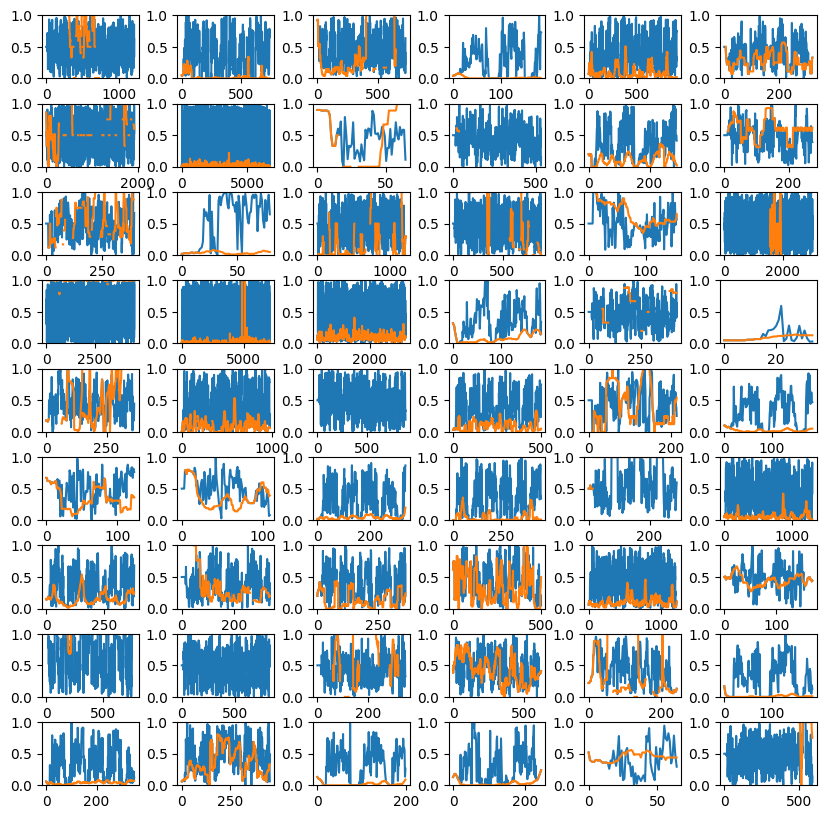

In [73]:
num_plots = 54
rows, cols = 9, 6
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.plot(predicted[i]) # blue
    ax.plot(real[i])
    ax.set_ylim(0, 1)
# 调整子图之间的间距
plt.subplots_adjust(hspace=0.4, wspace=0.4)

## training data sampling

In [74]:
predicted_train = []
real_train = []

In [75]:
total_length = 0

with tqdm(train_embedding, desc="生成序列", unit="seq") as pbar:
    for i in pbar:
        targets = i[0]
        amino = i[1]
        
        
        target_blocks, generated_blocks, length = diffusion.sample(model, targets, amino)
#         print(torch.stack(generated_blocks).shape, torch.stack(target_blocks).shape)
        # 目标序列和生辰序列不是完整序列
        generated_blocks = torch.stack(generated_blocks).permute(0, 2, 1)
        target_blocks = torch.stack(target_blocks).unsqueeze(1).permute(0, 2, 1)
        generated_sequence = merge_blocks(generated_blocks, original_length=length, overlap=5).squeeze(1).cpu()
        target_sequence = merge_blocks(target_blocks, original_length=length, overlap=5).squeeze(1).cpu()
        
        predicted_train.append(map_back_to_unit_range(generated_sequence))
        real_train.append(map_back_to_unit_range(target_sequence))
        
        # 更新统计信息
        total_length += length
        pbar.set_postfix({
            "avg_len": f"{total_length/(pbar.n+1):.1f}",
            "current_len": length
        })

生成序列: 89seq [1:02:18, 42.01s/seq, avg_len=1318.4, current_len=6725]


KeyboardInterrupt: 

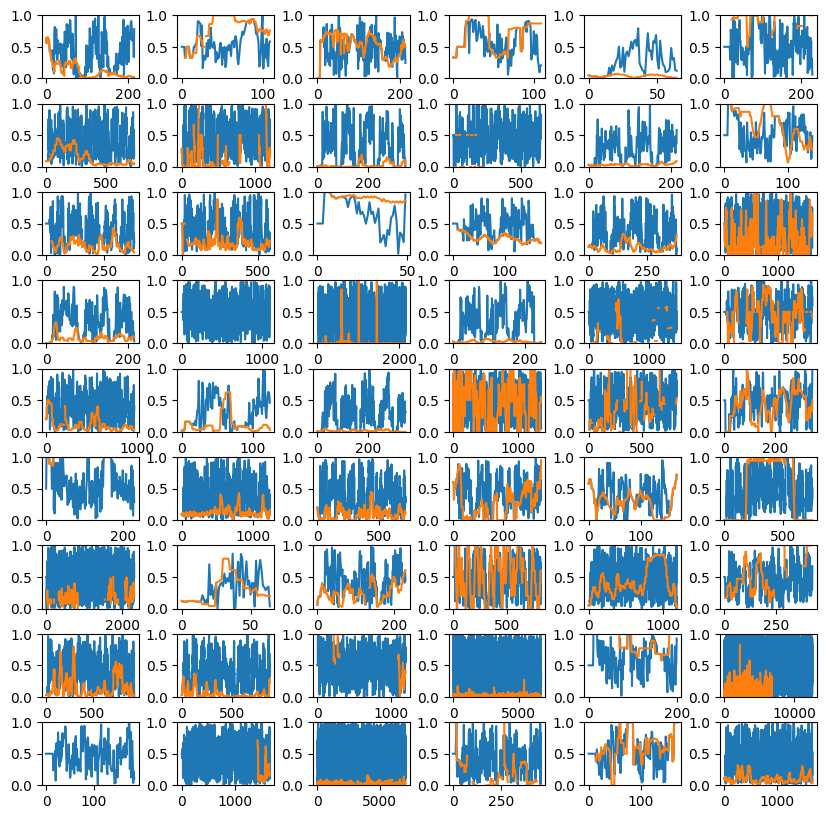

In [78]:
num_plots = 54
rows, cols = 9, 6
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.plot(predicted_train[16 + i]) # blue
    ax.plot(real_train[16 + i])
    ax.set_ylim(0, 1)
# 调整子图之间的间距
plt.subplots_adjust(hspace=0.4, wspace=0.4)

In [ ]:
# 保存整个模型
def save_full_model(model, path):
    torch.save(model, path)
    print(f"Full model saved to {path}")

save_full_model(model, "full_model.pth")

Full model saved to full_model.pth


In [ ]:
# 加载整个模型
def load_full_model(path):
    model = torch.load(path)
    model.to(device)  # 将模型移动到 GPU（如果可用）
    print(f"Full model loaded from {path}")
    return model

model = load_full_model("full_model.pth")

Full model loaded from full_model.pth


/tmp/ipykernel_906623/2354642266.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path)


In [ ]:
# 保存采样结果为 .pt 文件
def save_tensor(tensor, path):
    torch.save(tensor, path)
    print(f"Tensor saved to {path}")

# 加载 .pt 文件
def load_tensor(path):
    tensor = torch.load(path)
    print(f"Tensor loaded from {path}")
    return tensor

# 保存采样结果
# save_tensor(predicted_values, "predicted_values.pt")

In [ ]:
save_tensor(predicted, "predicted_values.pt")
save_tensor(real, "real_values.pt")

Tensor saved to predicted_values.pt
Tensor saved to real_values.pt


In [79]:
reals, predicteds = [], []
for i, j in zip(real, predicted):
    length = len(j.tolist())
    reals.extend(i.tolist()[:length])
    predicteds.extend(j.tolist())

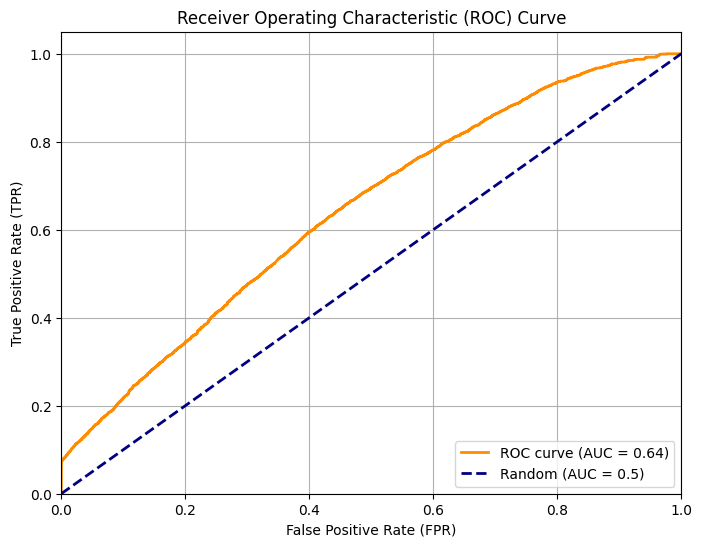

In [80]:
def threshold_list(input_list):
    return [1 if x >= 0.5 else 0 for x in input_list]


# 示例用法
my_list = reals
result = threshold_list(my_list)
# print(result)  # 输出: [0, 1, 0, 1, 1]

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 真实标签（0 或 1）
y_true = np.array(result)

# 预测概率（模型输出的概率，介于 0 和 1 之间）
y_score = predicteds

# 计算 ROC 曲线的 FPR, TPR 和阈值
fpr, tpr, thresholds = roc_curve(y_true, y_score)

# 计算 AUC
roc_auc = auc(fpr, tpr)

# 绘制 ROC 曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [83]:
reals_train, predicteds_train = [], []
for i, j in zip(real_train[16:], predicted_train[16:]):
    reals_train.extend(i.tolist())
    predicteds_train.extend(j.tolist())

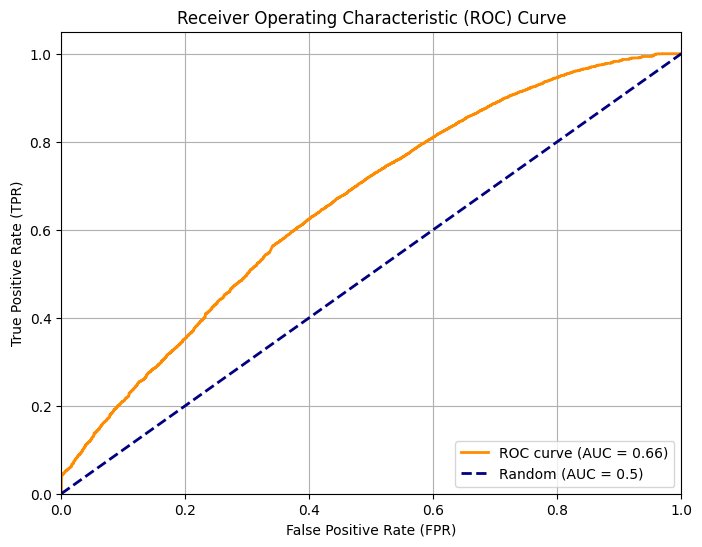

In [84]:
def threshold_list(input_list):
    return [1 if x >= 0.5 else 0 for x in input_list]


# 示例用法
my_list = reals_train
result = threshold_list(my_list)
# print(result)  # 输出: [0, 1, 0, 1, 1]

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 真实标签（0 或 1）
y_true = np.array(result)

# 预测概率（模型输出的概率，介于 0 和 1 之间）
y_score = predicteds_train

# 计算 ROC 曲线的 FPR, TPR 和阈值
fpr, tpr, thresholds = roc_curve(y_true, y_score)

# 计算 AUC
roc_auc = auc(fpr, tpr)

# 绘制 ROC 曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
